# Projected time for dataset creation

In [1]:
import time, random, os, re
from scf_guess_tools import Backend, load, calculate
rng_seed = 42
random.seed(rng_seed)

import multiprocessing
#! Strange workaround idk why it didn't work before
slurm_threads = int(os.environ.get("SLURM_CPUS_PER_TASK", multiprocessing.cpu_count()))
os.environ["OMP_NUM_THREADS"] = str(slurm_threads)
os.environ["MKL_NUM_THREADS"] = str(slurm_threads)
os.environ["NUMEXPR_MAX_THREADS"] = str(slurm_threads)  # NumPy multi-threading

import psi4, pyscf
pyscf.lib.num_threads(slurm_threads)
psi4.set_num_threads(slurm_threads)

  Threads set to 64 by Python driver.


In [2]:
def get_ref_energy(file):
    with open(file, "r") as f: 
        l2 = f.readlines()[1]
    return float(l2.split("\t")[11])

def create_valid_xyz(file): # why psi4???
        """Create a valid xyz which is suitable for psi"""
        with open(file, "r") as f: 
            raw = f.readlines()
        filename = os.path.basename(file).split(".")[0]
        cleaned = raw[:2]
        for c, l in enumerate(raw[2:]): #first 2 lines ok!
            atom_sym = l.split("\t")[0]
            if not re.match("^[A-Z][a-z]?$", atom_sym): 
                break
            xyz_data = "\t".join(l.split("\t")[:4])+"\n"
            cleaned.append(xyz_data)
        temp_path = f"/tmp/{filename}_valid.xyz" # got enough for now
        with open(temp_path, "w") as f: 
            f.writelines(cleaned)
        return temp_path

In [3]:
xyz_source = "../../datasets/QM9/xyz_c7h10o2/"
all_files = [os.path.join(xyz_source, f) for f in os.listdir(xyz_source) if f.endswith(".xyz")]

# take a small sample (10 for now)
sample_size = 10
files_to_calc = random.sample(all_files, sample_size)

basis_pyscf = "6-31G(2df,p)"
basis_path_psi4 = "../../datasets/basis/6-31g_2df_p.gbs"

pyscf_energies, psi4_energies = [], []
pyscf_times, psi4_times = [], []
reference_energies = [get_ref_energy(f) for f in files_to_calc]


In [ ]:
# psi4
backend = Backend.PSI
print("Starting calculations with Psi4")
for i, f in enumerate(files_to_calc):
    print(f"Calculating {i+1}/{sample_size}")
    start_ = time.time()
    valid_file = create_valid_xyz(f)
    mol = load(valid_file, backend, symmetry=False)
    wf = calculate(mol, basis_path_psi4, None, method="dft", functional="b3lyp", cache=False) # no cache to get true comp. time
    energy = wf.electronic_energy() + wf.nuclear_repulsion_energy()
    psi4_times.append(time.time() - start_)
    psi4_energies.append(energy)

Starting calculations with Psi4
Calculating 1/10

QcdbException BasisSetNotFound: BasisSet::construct: Unable to find a basis set for atom 1 for key BASIS among:
  Shell Entries: ['C']
  Basis Sets: [('spherical\n\n!----------------------------------------------------------------------\n! Basis Set Exchange\n! Version 0.11\n! https://www.basissetexchange.org\n!----------------------------------------------------------------------\n!   Basis set: 6-31G(2df,p)\n! Description: 6-31G(2df,p)\n!        Role: orbital\n!     Version: 0  (Data from the original Basis Set Exchange)\n!----------------------------------------------------------------------\n\n\n****\nH     0\nS    3   1.00\n     18.7311370              0.03349460\n      2.8253937              0.23472695\n      0.6401217              0.81375733\nS    1   1.00\n      0.1612778              1.00000000\nP    1   1.00\n      1.5000000              1.0000000\nP    1   1.00\n      0.3750000              1.0000000\n****\nC     0\nS    6   

BasisSetNotFound: BasisSet::construct: Unable to find a basis set for atom 1 for key BASIS among:
  Shell Entries: ['C']
  Basis Sets: [('spherical\n\n!----------------------------------------------------------------------\n! Basis Set Exchange\n! Version 0.11\n! https://www.basissetexchange.org\n!----------------------------------------------------------------------\n!   Basis set: 6-31G(2df,p)\n! Description: 6-31G(2df,p)\n!        Role: orbital\n!     Version: 0  (Data from the original Basis Set Exchange)\n!----------------------------------------------------------------------\n\n\n****\nH     0\nS    3   1.00\n     18.7311370              0.03349460\n      2.8253937              0.23472695\n      0.6401217              0.81375733\nS    1   1.00\n      0.1612778              1.00000000\nP    1   1.00\n      1.5000000              1.0000000\nP    1   1.00\n      0.3750000              1.0000000\n****\nC     0\nS    6   1.00\n   3047.5249000              0.0018347\n    457.3695100              0.0140373\n    103.9486900              0.0688426\n     29.2101550              0.2321844\n      9.2866630              0.4679413\n      3.1639270              0.3623120\nSP   3   1.00\n      7.8682724             -0.1193324              0.0689991\n      1.8812885             -0.1608542              0.3164240\n      0.5442493              1.1434564              0.7443083\nSP   1   1.00\n      0.1687144              1.0000000              1.0000000\nD    1   1.00\n      1.2520000              1.0000000\nD    1   1.00\n      0.3130000              1.0000000\nF    1   1.00\n      0.8000000              1.0000000\n****\nO     0\nS    6   1.00\n   5484.6717000              0.0018311\n    825.2349500              0.0139501\n    188.0469600              0.0684451\n     52.9645000              0.2327143\n     16.8975700              0.4701930\n      5.7996353              0.3585209\nSP   3   1.00\n     15.5396160             -0.1107775              0.0708743\n      3.5999336             -0.1480263              0.3397528\n      1.0137618              1.1307670              0.7271586\nSP   1   1.00\n      0.2700058              1.0000000              1.0000000\nD    1   1.00\n      2.5840000              1.0000000\nD    1   1.00\n      0.6460000              1.0000000\nF    1   1.00\n      1.4000000              1.0000000\n****\n', 'spherical\n\n!----------------------------------------------------------------------\n! Basis Set Exchange\n! Version 0.11\n! https://www.basissetexchange.org\n!----------------------------------------------------------------------\n!   Basis set: 6-31G(2df,p)\n! Description: 6-31G(2df,p)\n!        Role: orbital\n!     Version: 0  (Data from the original Basis Set Exchange)\n!----------------------------------------------------------------------\n\n\n****\nH     0\nS    3   1.00\n     18.7311370              0.03349460\n      2.8253937              0.23472695\n      0.6401217              0.81375733\nS    1   1.00\n      0.1612778              1.00000000\nP    1   1.00\n      1.5000000              1.0000000\nP    1   1.00\n      0.3750000              1.0000000\n****\nC     0\nS    6   1.00\n   3047.5249000              0.0018347\n    457.3695100              0.0140373\n    103.9486900              0.0688426\n     29.2101550              0.2321844\n      9.2866630              0.4679413\n      3.1639270              0.3623120\nSP   3   1.00\n      7.8682724             -0.1193324              0.0689991\n      1.8812885             -0.1608542              0.3164240\n      0.5442493              1.1434564              0.7443083\nSP   1   1.00\n      0.1687144              1.0000000              1.0000000\nD    1   1.00\n      1.2520000              1.0000000\nD    1   1.00\n      0.3130000              1.0000000\nF    1   1.00\n      0.8000000              1.0000000\n****\nO     0\nS    6   1.00\n   5484.6717000              0.0018311\n    825.2349500              0.0139501\n    188.0469600              0.0684451\n     52.9645000              0.2327143\n     16.8975700              0.4701930\n      5.7996353              0.3585209\nSP   3   1.00\n     15.5396160             -0.1107775              0.0708743\n      3.5999336             -0.1480263              0.3397528\n      1.0137618              1.1307670              0.7271586\nSP   1   1.00\n      0.2700058              1.0000000              1.0000000\nD    1   1.00\n      2.5840000              1.0000000\nD    1   1.00\n      0.6460000              1.0000000\nF    1   1.00\n      1.4000000              1.0000000\n****\n', None)]
  File Path: /home/ewachmann/REPOS/Masterarbeit/skripts/bench, /home/ewachmann/REPOS/Masterarbeit/skripts/bench, /home/ewachmann/.conda/envs/scf_tools_311/share/psi4/basis
  Input Blocks: 


In [4]:
# pyscf
backend = Backend.PY
print("Starting calculations with PySCF")
for i, f in enumerate(files_to_calc):
    print(f"Calculating {i+1}/{sample_size}")
    start_ = time.time()
    mol = load(f, backend,  symmetry=False)
    wf = calculate(mol, basis_pyscf, None, method="dft", functional="b3lypg", cache=False) # no cache to get true comp. time
    energy = wf.electronic_energy() + wf.nuclear_repulsion_energy()
    pyscf_times.append(time.time() - start_)
    pyscf_energies.append(energy)

Starting calculations with PySCF
Calculating 1/10
converged SCF energy = -423.163495004697
Calculating 2/10
converged SCF energy = -423.179727190771
Calculating 3/10
converged SCF energy = -423.101808799448
Calculating 4/10
converged SCF energy = -423.234271831802
Calculating 5/10
converged SCF energy = -423.124224208985
Calculating 6/10
converged SCF energy = -423.127515807203
Calculating 7/10
converged SCF energy = -423.189753206402
Calculating 8/10
converged SCF energy = -423.156456436258
Calculating 9/10
converged SCF energy = -423.158310366741
Calculating 10/10
converged SCF energy = -423.181182466479


Mean time PySCF: 23.04 s -> 39.0 h for 6095 molecules


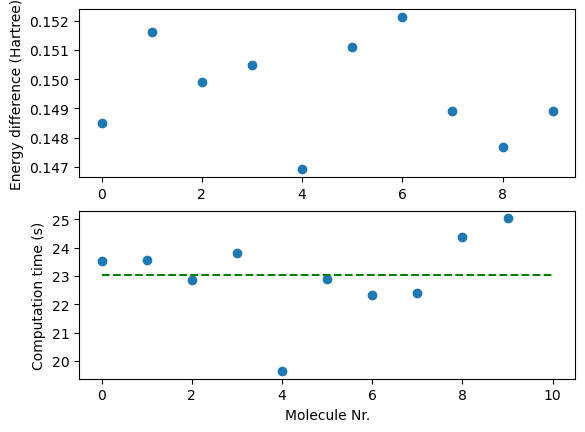

In [21]:
import matplotlib.pyplot as plt
import numpy as np
N = 6095

energy_diffs_pyscf = [(ref - calc) for ref, calc in zip(reference_energies, pyscf_energies)]
energy_diffs_psi4 = [(ref - calc) for ref, calc in zip(reference_energies, psi4_energies)]

mean_time_pyscf = np.mean(pyscf_times)
std_time_pyscf = np.std(pyscf_times)

# mean_time_psi4 = np.mean(psi4_times)
# std_time_psi4 = np.std(psi4_times)

fig, ax = plt.subplots(2,1)
ax[0].scatter(np.arange(len(energy_diffs_pyscf)), energy_diffs_pyscf, label="PySCF energy")
ax[1].scatter(np.arange(len(energy_diffs_pyscf)), pyscf_times, label="PySCF time")
ax[0].set_ylabel("Energy difference (Hartree)")
ax[1].set_ylabel("Computation time (s)")
ax[1].set_xlabel("Molecule Nr.")
ax[1].hlines(mean_time_pyscf, 0, len(pyscf_times), colors="g", linestyles="dashed")

print(f"Mean time PySCF: {round(mean_time_pyscf,2)} s -> {round(mean_time_pyscf*N / 3600,1)} h for {N} molecules")
